In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset
import torchvision
import matplotlib.patches as patches
import torchvision.transforms as transforms

import os
import time
import torch
import sys
import argparse
sys.path.insert(0, '../../shared_code')
# from network import *
from model_loader_func import * 
from dataloader_func import resize_image,add_noise_torch, rescale_image_range,int_to_float,rgb_to_gray, patch_generator, single_image_loader,load_dataset,prep_dataset
from quality_metrics_func import *
from linear_approx import *
from inverse_tasks_func import synthesis
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im,plot_matching_patches
from algorithm_inv_prob import * 
from trainer import make_loader
from synthetic_data_generators import *

%matplotlib inline

In [2]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

2.5.0+cu124


device(type='cuda')

In [3]:
denoisers = {}


root_path = '/mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/'

paths = { 'mixture-gray':'UNet_flex/ovals_texture/0to255_RF_84x84_set_size_250000_80x80/',           
            'conditional-gray':'UNet_conditional_mean_matching/ovals_texture/0to255_RF_84x84_set_size_250000_80x80/'
        }

groups = paths.keys()

for group in groups: 
    path = root_path + paths[group]

    print('loading group ' , group )
    denoisers[group] = load_learned_model(path, print_args=True)
    start_time_total = time.time()        
    print("--- %s seconds ---" % (round(time.time() - start_time_total)))
      

loading group  mixture-gray
*************** saved arguments:*************
arch_name UNet_flex
lr 0.001
batch_size 512
num_epochs 1000
lr_freq 100
loss_weight False
noise_level_range [0, 255]
quadratic_noise True
rescale False
swap False
set_size 250000
imagenet_subset_ids None
self_cond False
data_name ovals_texture
data_root_path /mnt/home/zkadkhodaie/ceph/datasets/
dir_name /mnt/home/zkadkhodaie/ceph/21_hierarchical_conditional_prior/denoisers/UNet_flex/ovals_texture/0to255_RF_84x84_set_size_250000_80x80
optional_dir_label None
device cuda
debug False
kernel_size 3
padding 1
skip True
num_channels 1
bias True
RF 84
coarse True
num_kernels [16, 32, 64, 128]
num_blocks 3
num_enc_conv [2, 2, 2]
num_mid_conv 3
num_dec_conv [2, 2, 2]
NormType LayerNorm
match_only_mid True
nonlinear_enc True
******************************************************
number of parameters is  627921
train mode: False
--- 0 seconds ---
loading group  conditional-gray
*************** saved arguments:*************


In [4]:
blocks = ['enc1', 'enc2','enc3','mid','dec3', 'dec2']


In [5]:
                              
def make_oval_textures_dataset(set_size, aspect_ratios, num=20, 
                              canvas_size=(80, 80), min_area=60, max_area=100, 
                              edge_smoothness=0.1):
    N = int(set_size/len(aspect_ratios))
 
    # train
    all_data_train = []
    for aspect_ratio in aspect_ratios: 
        ovals = []
        for i in range(N):
            im = generate_ovals_texture(aspect_ratio, num, 
                              canvas_size, min_area, max_area, 
                              edge_smoothness )
            ovals.append(im)
        ovals = torch.stack(ovals).unsqueeze(1)
        all_data_train.append(ovals)

    # test
    N = 100
    all_data_test = []
    for aspect_ratio in aspect_ratios: 
        ovals = []    
        for i in range(N):
            im = generate_ovals_texture(aspect_ratio, num, 
                                  canvas_size, min_area, max_area, 
                                  edge_smoothness )
            ovals.append(im)
        ovals = torch.stack(ovals).unsqueeze(1)
        all_data_test.append(ovals)
    
    return all_data_train, all_data_test


In [6]:
train_sets, test_sets = make_oval_textures_dataset(500, [.2,.5, 1, 2, 5])

In [7]:
print('number of images in each class:', train_sets[0].shape)
K = train_sets[0].shape[2]
n_channels = train_sets[0].shape[1]
print('number of classes: ', len(train_sets))

number of images in each class: torch.Size([100, 1, 80, 80])
number of classes:  5


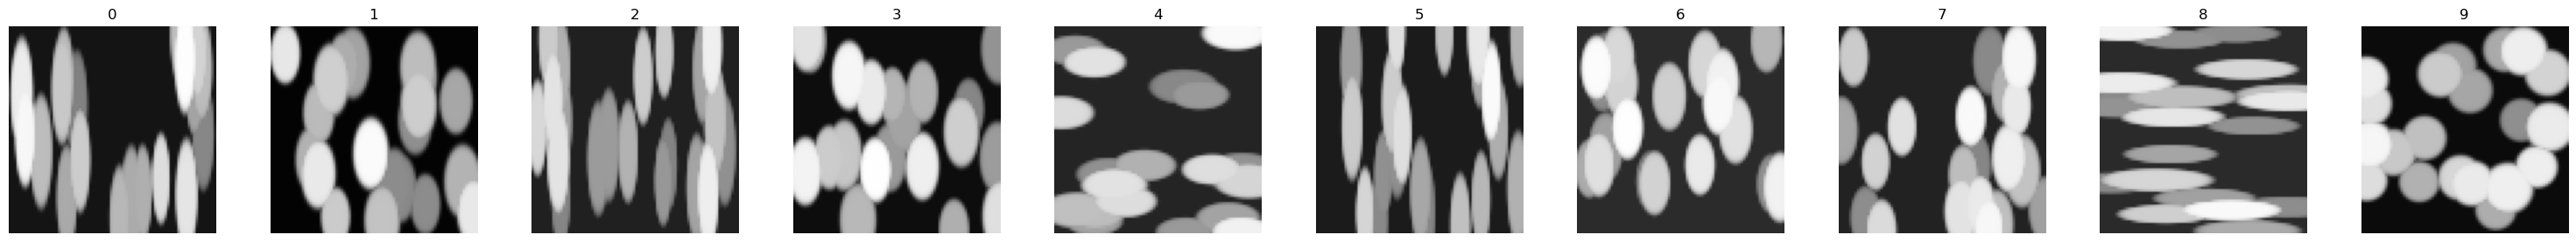

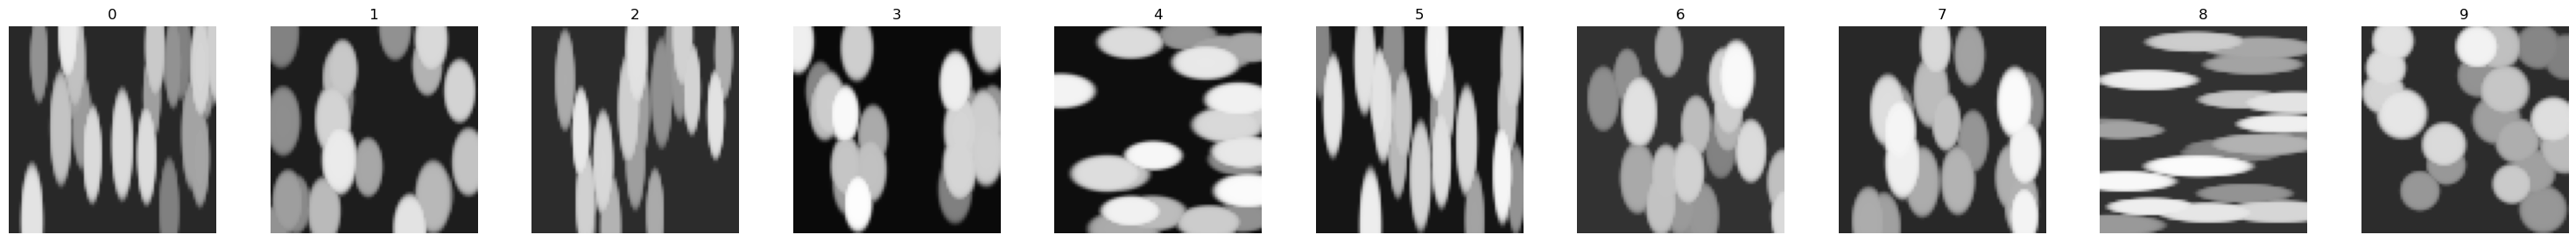

total number of train images: 500


In [8]:
## shuffle train and test images and put them in one tensor 
loader, loader_cond = make_loader(dataset=train_sets, batch_size=512, dataset_cond=train_sets, self_cond =False, )    
train ={}
train['inp']  = loader.dataset
train['cond'] = loader_cond.dataset
show_im_set(train['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(train['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of train images:',train['inp'].shape[0])

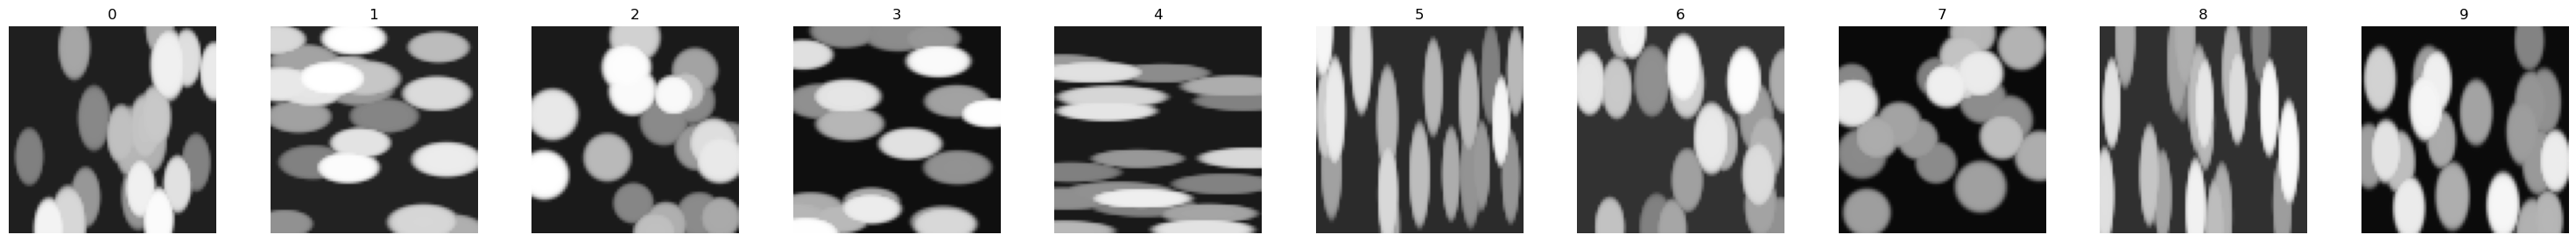

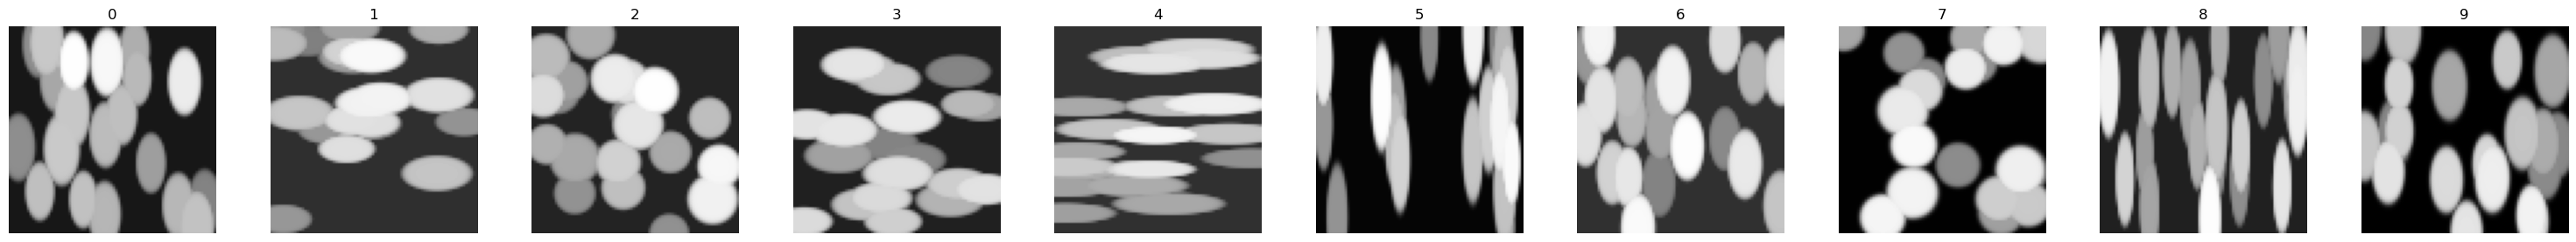

total number of test images: 500


In [9]:
loader, loader_cond = make_loader(dataset=test_sets, batch_size=256, dataset_cond=test_sets, self_cond =False)        
test ={}
test['inp']  = loader.dataset[0:1024]
test['cond'] = loader_cond.dataset[0:1024]
show_im_set(test['inp'][0:10], n_columns=10, vmin=0, vmax = 1)
show_im_set(test['cond'][0:10], n_columns=10, vmin=0, vmax = 1)
print('total number of test images:',test['inp'].shape[0])


tensor(0.4278)


80

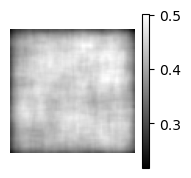

In [10]:
dist_mean = test['inp'].mean(0)
plot_single_im(dist_mean, colorbar=True)
print(dist_mean.mean())
K = dist_mean.shape[2]
K

In [11]:

def get_channel_means(unet, x1, x2=None, average_phi=False, with_params=True, return_activations = False): 
    '''
    returns means of channels (phi) of a conditional or regular UNet
    if conditional unet: returns means of channels for either input or conditioner image, or both
    if unconditional unet: returns means of channels for input
    @noisy: of shape N,C,H,W
    @with_param: important: set to False if phi is computed to be given to the network (instead of x)
    '''    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # set network in saving mode
    unet.save_means = True    
    if return_activations: 
        unet.save_activations = True

    #compute the responses 
    with torch.no_grad():
        try: #for conditional model
            if x2 is None: #if only conditioner image is given 
                out = unet(x1.to(device), x1.to(device), average_phi)
            else: # if a noisy input is also given
                out = unet(x2.to(device), x1.to(device), average_phi)
                x_means = unet.stored_x_means
                
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            
        except TypeError: # for the unconditional model
            out = unet(x1.to(device))
            x_c_means = unet.stored_x_c_means
            x_c = unet.stored_x_c
            if average_phi: 
                for i in range(len(x_c_means)): 
                    x_c_means[i] = x_c_means[i].mean(0,keepdim=True)
            
    
    unet.save_means = False
    unet.save_activations = False


    if with_params:   
        try:
            params = get_matching_params(unet)
            for i in range(len(params)): 
                x_c_means[i] = x_c_means[i] * params[i]
        except AttributeError: 
            pass

    if (x2 is None) & (return_activations is False): 
        return x_c_means
    elif (x2 is None) & (return_activations is True): 
        return x_c_means, x_c
    elif (x2 is not None) & (return_activations is False): 
        return x_c_means, x_means
    else: 
        return x_c_means, x_means, x_c

def get_matching_params(unet): 
    params = []
    for l in range(len(unet.encoder_matching_params)):
        params.append(unet.encoder_matching_params[str(l)].detach().to(device))
    params.append(unet.mid_matching_params.detach().to(device))
    for l in range(len(unet.decoder_matching_params)-1, 0,-1):
        params.append(unet.decoder_matching_params[str(l)].detach().to(device))
    return params

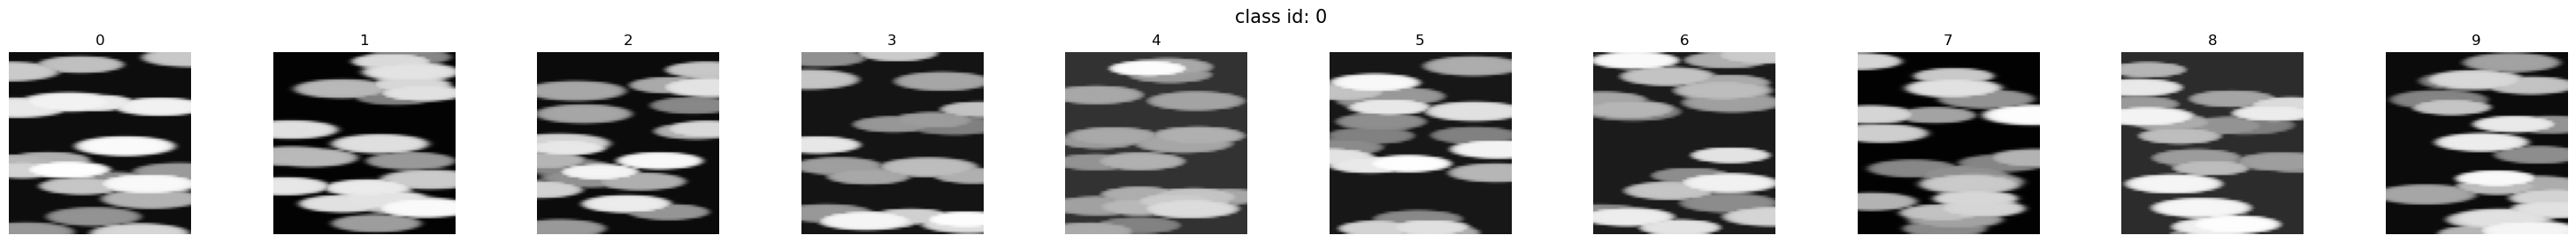

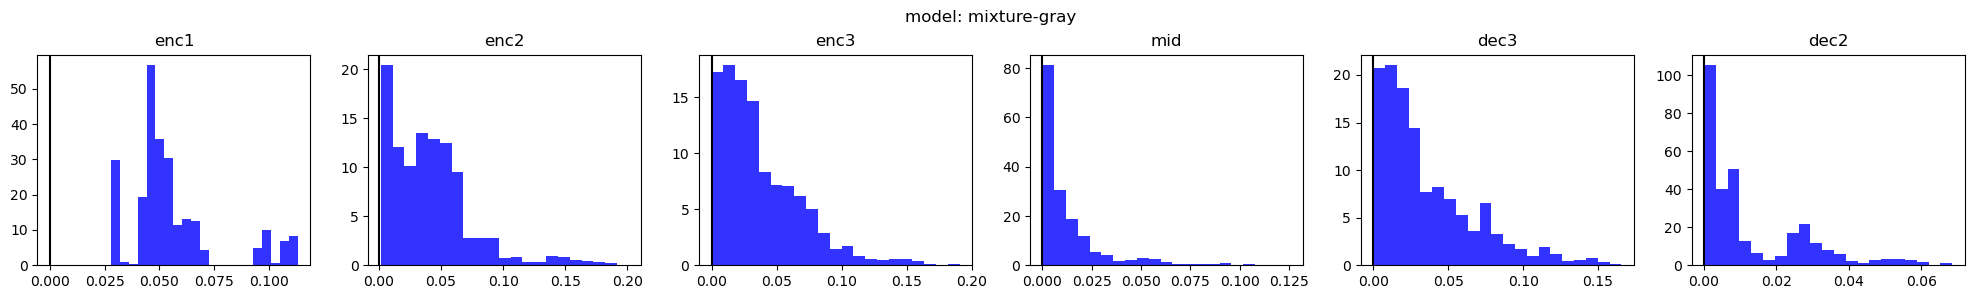

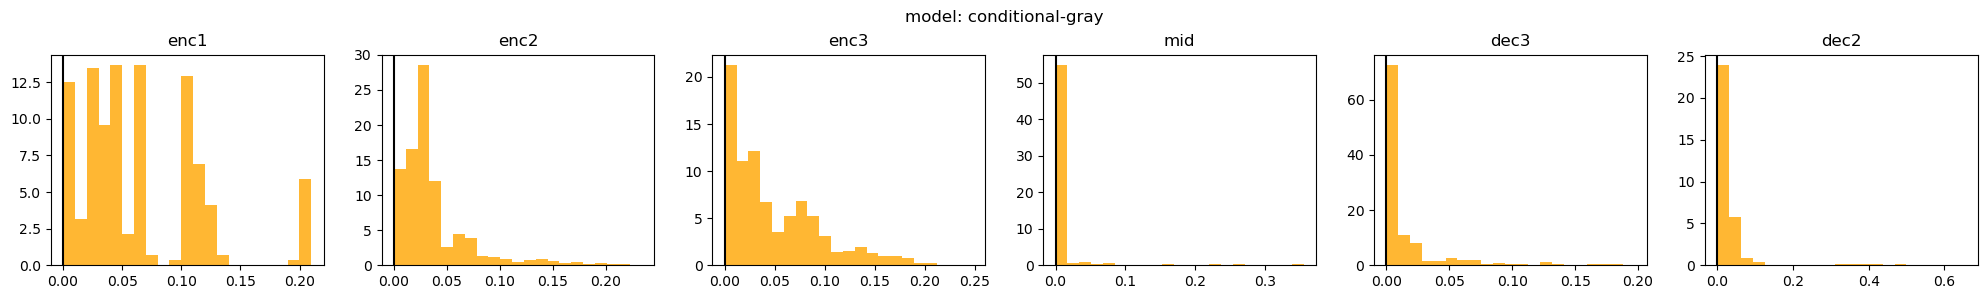

In [15]:
c = 0
im_cond = train_sets[c]
show_im_set(im_cond[0:10],  n_columns=10, label = 'class id: ' + str(c), vmin=0, vmax = 1)

sig = 100 #sigma used for mixture model input
colors = ['blue', 'orange']
for j,group in zip(range(2),['mixture-gray', 'conditional-gray']): 
    im_cond = train_sets[c]

    f , axs = plt.subplots(1,len(blocks), figsize=(20,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)    
    plt.tight_layout()    
    if 'gray' in group:
        im_cond = im_cond.mean(dim = 1, keepdim=True)
    if 'mixture' in group: 
        im_cond = add_noise_torch(im_cond, sig)[0]
    else: 
        im_cond = im_cond
        
    phi = get_channel_means(denoisers[group], im_cond ,average_phi=False, with_params=True)
        
    for i in range(len(blocks)): 
        axs[i].hist( (phi[i].flatten()).cpu().abs() , bins=21, density=True, label = group, alpha = .8, color = colors[j] )
        axs[i].set_title(blocks[i])
        axs[i].axvline(0, color='k')
        


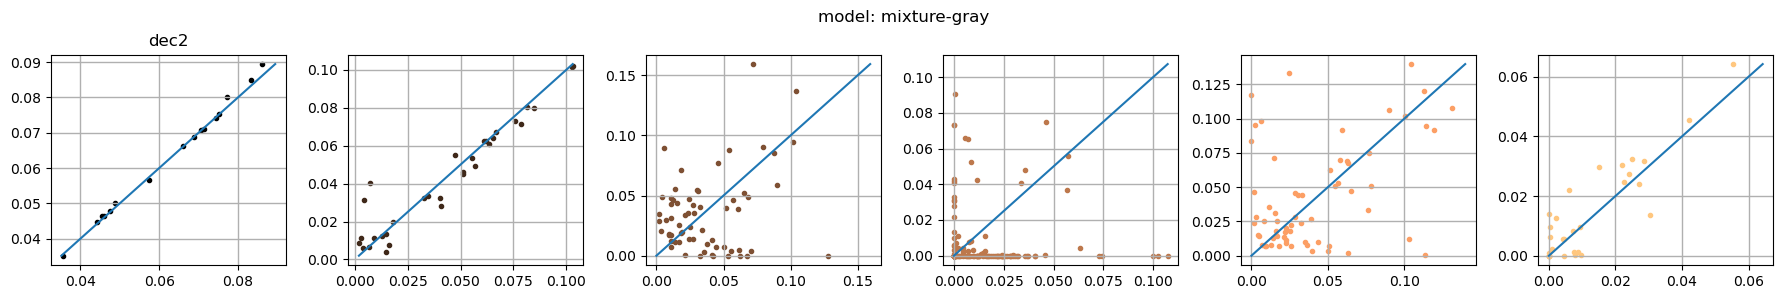

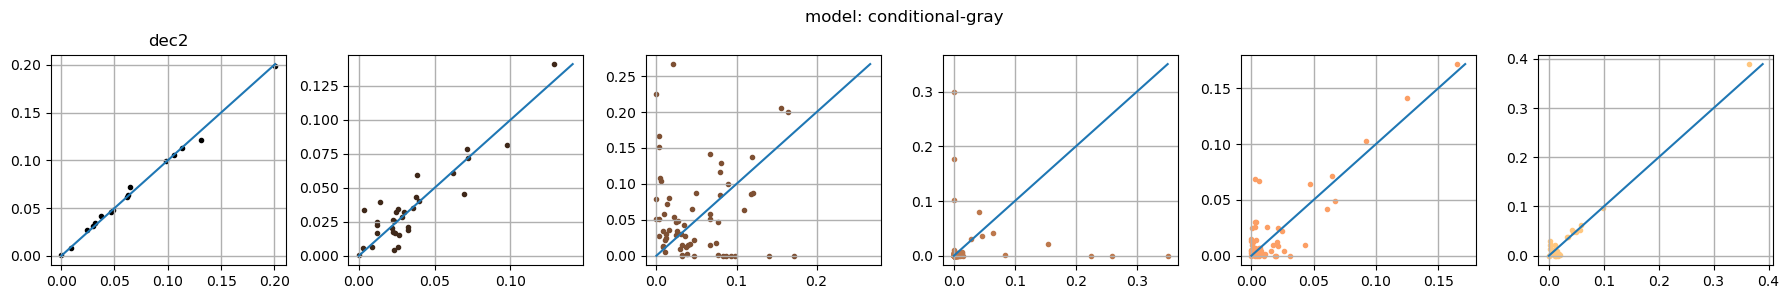

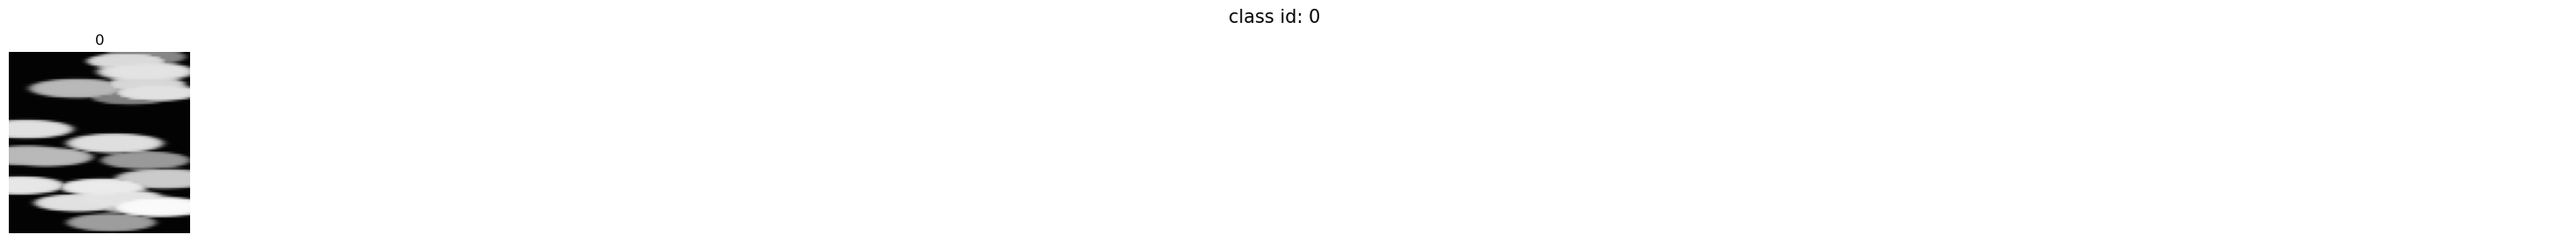

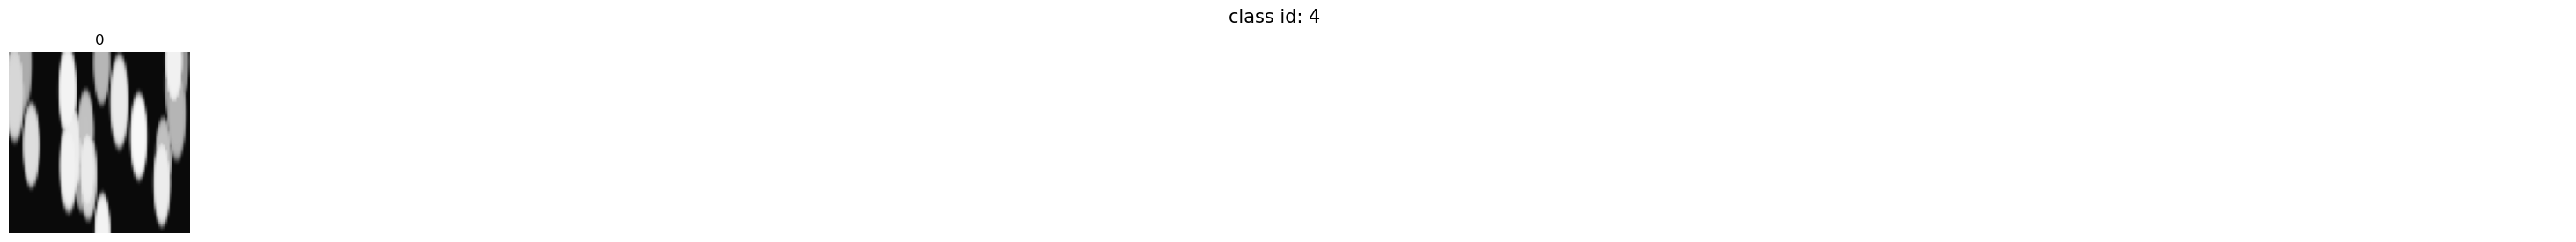

In [18]:
### compare two classes against each other ####
c1 = 0
c2 = 4
sig = 250

for group in ['mixture-gray', 'conditional-gray']:    
    im1_cond = train_sets[c1][1:2]
    im2_cond = train_sets[c2][0:1]    
    if 'gray' in group: 
        im1_cond = im1_cond.mean(dim =1,keepdim=True )
        im2_cond = im2_cond.mean(dim =1, keepdim=True )

    if 'mixture' in group:
        phi_xc, x_c1 = get_channel_means(denoisers[group], add_noise_torch(im1_cond, sig)[0],average_phi=True,with_params=True , return_activations=True)
        phi_2, x_c2 = get_channel_means(denoisers[group], add_noise_torch(im2_cond, sig)[0] ,average_phi=True, with_params=True , return_activations=True)
    else: 
        phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=True,with_params=True , return_activations=True)
        phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=True, with_params=True , return_activations=True)
        
    f , axs = plt.subplots(1,len(blocks), figsize=(18,3), sharex = False, sharey=False)
    f.suptitle('model: ' + group)
    plt.tight_layout()
    axs = axs.ravel()
    colormap = plt.cm.copper #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.linspace(0, 1,len(blocks))]
    for i in range(len(blocks)): 
        axs[i].scatter( (phi_xc[i]).cpu().abs(), (phi_2[i]).cpu().abs(), marker ='.' , color=plot_colors[i])
    
        axs[0].set_title(blocks[i])
        axs[i].grid(  linewidth=1);
        axs[i].plot([min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())],
                    [min((phi_xc[i]).cpu().abs().min(), (phi_2[i]).cpu().abs().min()),max((phi_xc[i]).cpu().abs().max(), (phi_2[i]).cpu().abs().max())])

show_im_set(im1_cond[0:10],  n_columns=10, label = 'class id: ' + str(c1), vmin=0, vmax = 1)
show_im_set(im2_cond[0:10], n_columns=10,  label = 'class id: ' + str(c2),vmin=0, vmax = 1)


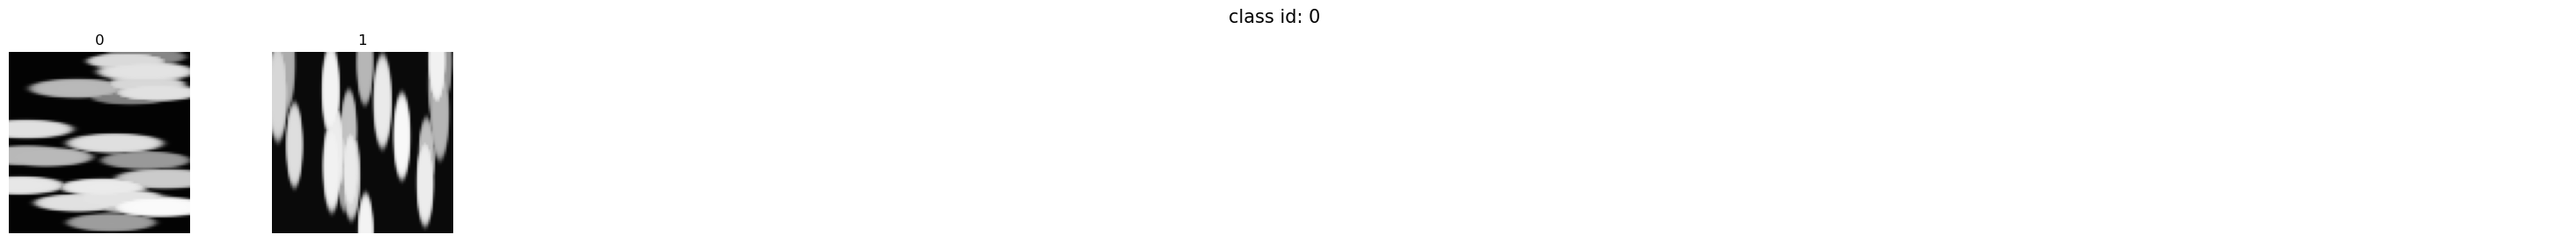

[107  37  32  43   5   9  68  93  58  11  41 116  49  64  21   3  98  50
   7  71]
[91 55 30 68  9 93 43 26 11 15 50 62 41 24 23 75 76 96 82 90]


In [21]:
### for the conditional model 
group = 'conditional-gray'
    
show_im_set( torch.vstack([im1_cond, im2_cond]),  n_columns=10, label = 'class id: ' + str(c1), vmin=0, vmax = 1)
        
phi_xc, x_c1 = get_channel_means(denoisers[group], im1_cond,average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], im2_cond ,average_phi=False, with_params=True , return_activations=True)

block = 3
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

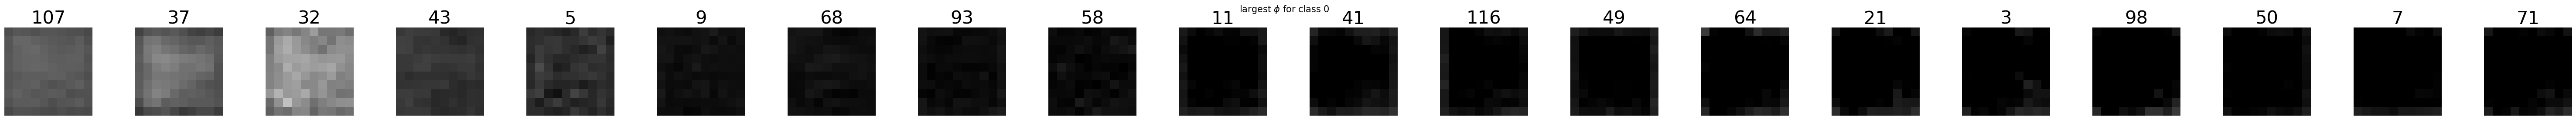

largest $\phi$ for class 0


In [22]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

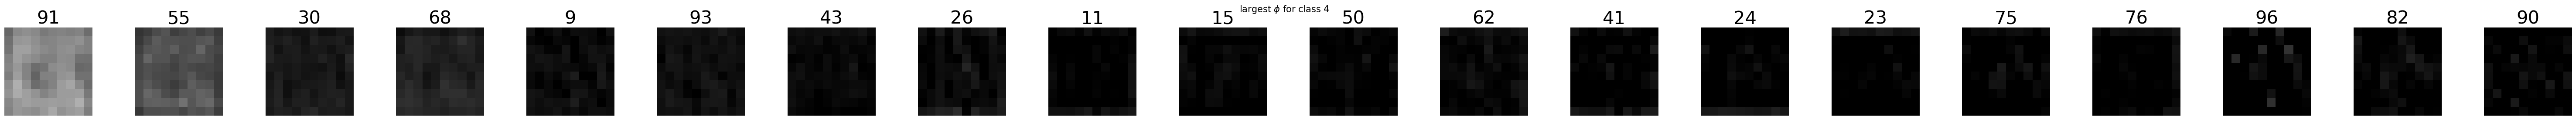

largest $\phi$ for class 4


In [23]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

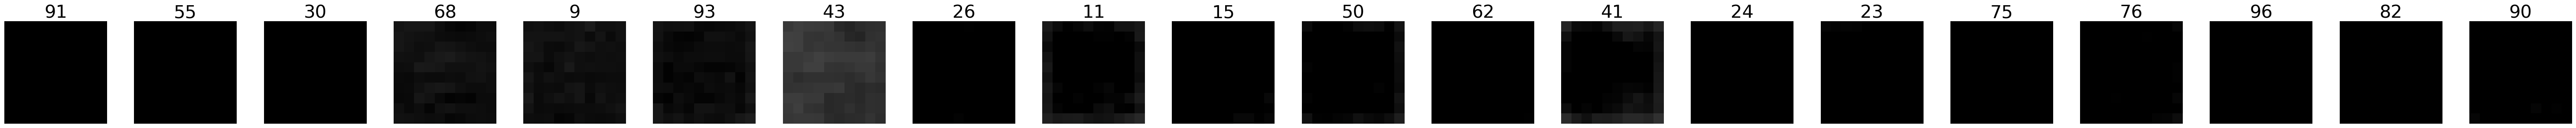

channels of image 0 for largert $\phi$ of image 4


In [24]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

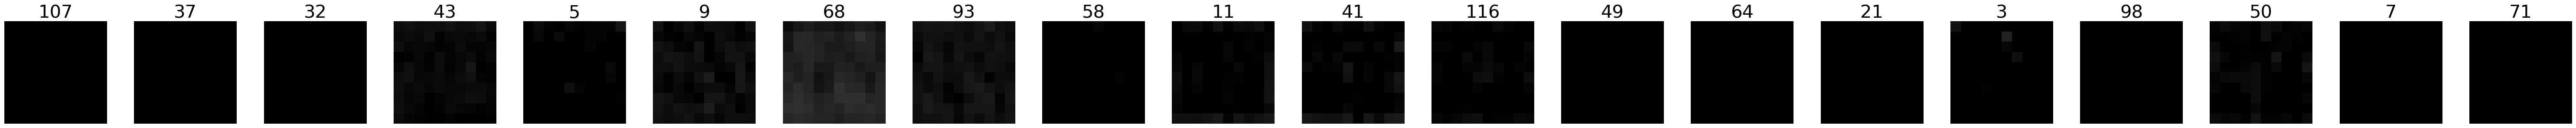

channels of image 4 for largert $\phi$ of image 0


In [25]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+ ' for largert $\phi$ of image ' + str(c1) )

In [28]:
### for the mixture model 
group = 'mixture-gray'
sig = 100
phi_xc, x_c1 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im1_cond,noise_level=sig)[0],
                                average_phi=False,with_params=True , return_activations=True)
phi_2, x_c2 = get_channel_means(denoisers[group], 
                                x1=add_noise_torch(im2_cond,noise_level=sig)[0],
                                average_phi=False, with_params=True , return_activations=True)

block = 3
im_n = 0 # pick one image from the class
# get the top active phis
ids_1 = phi_xc[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
ids_2 = phi_2[block][im_n:im_n+1].sort(dim = 1, descending =True)[1].flatten()[0:20].cpu().numpy()
print(ids_1)
print(ids_2)
  

[ 59  14  42  63  18 111 105  30 114  95   8  70  57  55  68 127  77  89
   2  44]
[  1  52  95  98  15  24  93  30  57 121 117  44 114  83  17  91  22   3
 124 115]


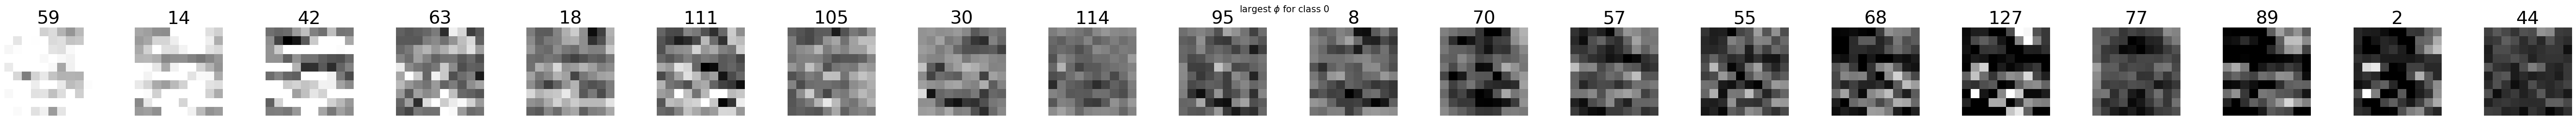

largest $\phi$ for class 0


In [29]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() , label='largest $\phi$ for class ' + str(c1) )
print('largest $\phi$ for class ' + str(c1) )

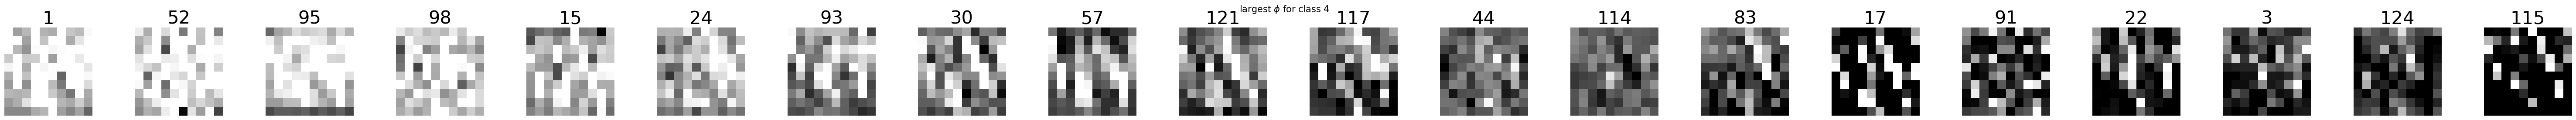

largest $\phi$ for class 4


In [30]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ,  label='largest $\phi$ for class ' + str(c2) ) 
print('largest $\phi$ for class ' + str(c2) )

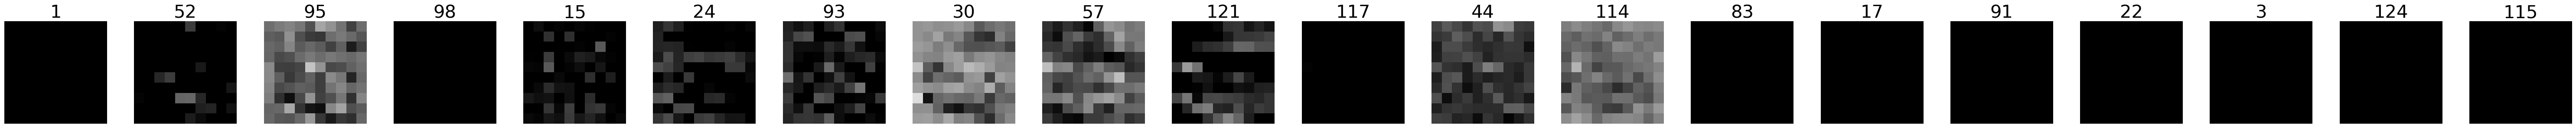

channels of image 0 for largert $\phi$ of image 4


In [31]:
show_im_set(x_c1[block][im_n].unsqueeze(1)[ids_2] , 
            sub_labels= ids_2,            
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_xc[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c1)+' for largert $\phi$ of image ' + str(c2) )

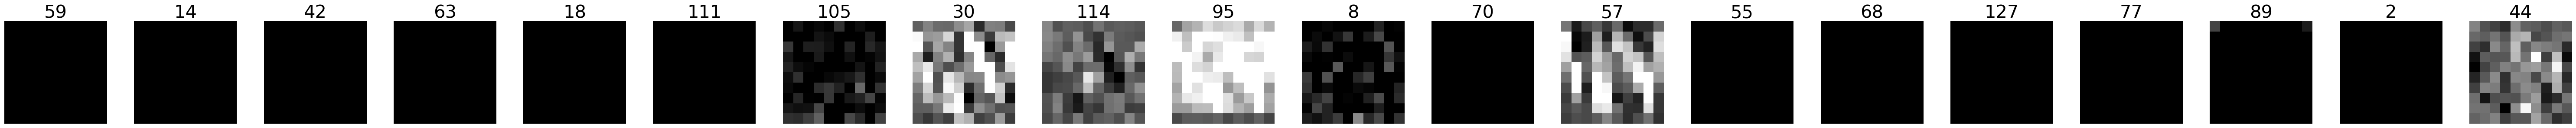

channels of image 4 for largert $\phi$ of image 0


In [32]:
show_im_set(x_c2[block][im_n].unsqueeze(1)[ids_1] , 
            sub_labels= ids_1,                        
            n_columns=20  , colorbar=False, vmin=0, vmax = phi_2[block][im_n:im_n+1].max() ) 
print('channels of image '+str(c2)+' for largert $\phi$ of image ' + str(c1) )

tensor([ 0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,  0.7000,  0.8000,
         0.9000,  1.0000,  1.1111,  1.2500,  1.4286,  1.6667,  2.0000,  2.5000,
         3.3333,  5.0000, 10.0000])

In [53]:
cond_ims = []
for aspect_ratio in torch.concatenate((torch.linspace(.1, 1, 10), 1/torch.linspace(.1, 1, 10).flip(dims =(0,))[1::] ) ):
    
    x = generate_ovals_texture(aspect_ratio, num=20, canvas_size=(80, 80), min_area=60, max_area=100, 
                           edge_smoothness=0.1)
    cond_ims.append(x)
cond_ims = torch.stack(cond_ims).unsqueeze(1)
cond_ims.shape

torch.Size([19, 1, 80, 80])

In [54]:
def plot_phi_corr(cond_ims, sig=0): 
    for group in ['mixture-gray','conditional-gray' ]:
        if 'gray' in group.split('-'): 
            cond_ims = cond_ims.mean(dim = 1, keepdim = True)
        if 'mixture' in group: 
            phi_xc = get_channel_means(denoisers[group], add_noise_torch(cond_ims, sig)[0],average_phi=False,with_params=True , return_activations=False)
        else: 
            phi_xc = get_channel_means(denoisers[group], cond_ims,average_phi=False,with_params=True , return_activations=False)

        
        f, axs = plt.subplots(1, len(blocks), figsize = (18,3))
        plt.suptitle(group)
        for block in range(len(blocks)): 
            axs[block].imshow(torch.abs(torch.corrcoef(phi_xc[block].squeeze() )).cpu() , 'gray',vmin=0, vmax = 1)
            axs[block].tick_params(bottom=False,top = False, right = False, left=False)
            axs[block].set_xticks([])  
            axs[block].set_yticks([])      
            axs[block].set_title(blocks[block])
        plt.tight_layout()
        
    show_im_set(cond_ims, n_columns=len(cond_ims), vmin=0, vmax = 1)


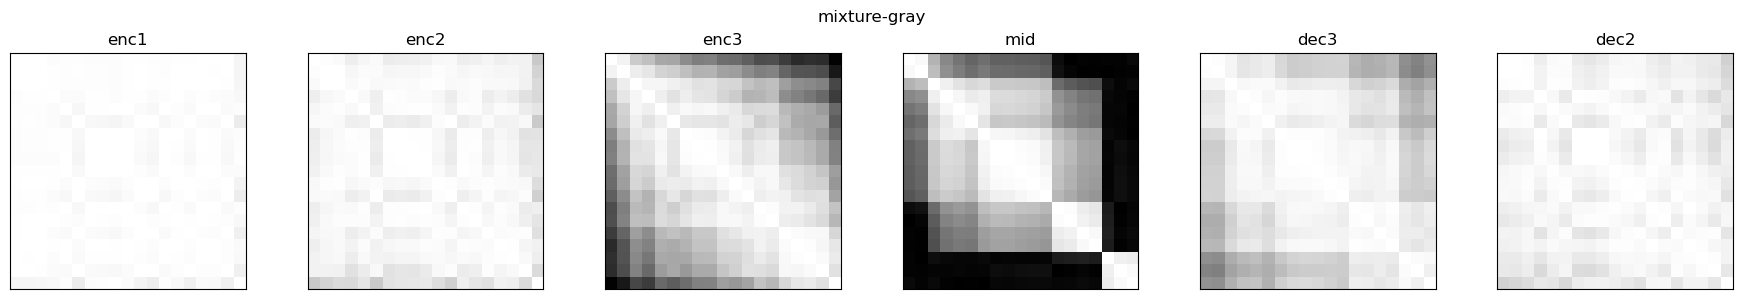

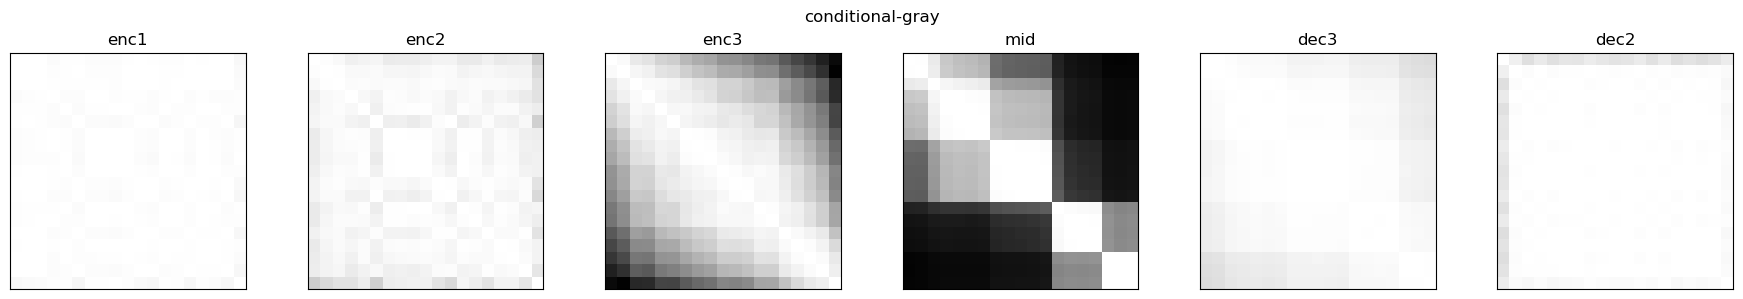

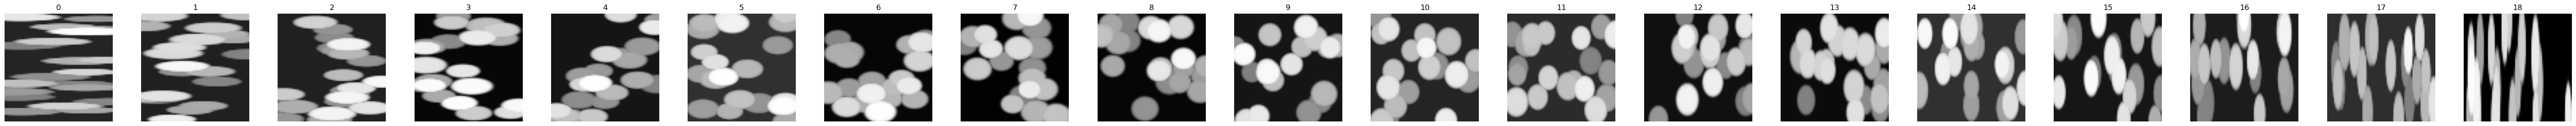

In [56]:
plot_phi_corr(cond_ims, sig = 100)